# Policy Gradient and Actor-Critic

Recall that the reinforcement learning objective is to learn a $ \theta^∗$ that maximizes the objective function:
$$J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}}[R(\tau )] = \mathbb{E}_{\tau \sim \pi_{\theta}}\left[\sum_{t=0}^T R(s_t, a_t)\right]$$

How can we use the data and compute the best policy?
* **Q-Learning (Value Function):** We can consider all transitions seen so far, but we're trying to learn the optimal Q-function by minimizing the Bellman-/TD-error instead of optimizing the policy directly. The corresponding policy is obtained via the connection between $Q^*$ and $\pi^*$: the actions taken by the Q-learning agent are given by
$$a = \arg \max_a Q_{\theta}(s,a)$$

* **Policy gradient methods:** We directly optimize the parameterized policy, but due to changes of the policy during the training, the input data (observation and reward distributions) are not stationary and hence we cannot use all gathered data.
$$\nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}{\left[
    \left(\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t)\right) \left(\sum_{t=0}^T R(s_{t}, a_{t})\right)\right]}$$

Taking a step with this gradient pushes up the log-probabilities of each action in proportion to $R(\tau)$.

$$\theta = \theta + \alpha \nabla_{\theta} J(\pi_{\theta})$$
In practice, the expectation over trajectories $\tau$ can be approximated with a batch of $N$ sampled trajectories:

$$\nabla_{\theta} J(\pi_{\theta}) \approx \frac{1}{N} \sum_{i=1}^{N}\bigg(
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t^{(i)}|s_t^{(i)})\bigg) \bigg( \sum_{t=0}^T R(s_t^{(i)}, a_t^{(i)})\bigg)$$
    
Here we see that the policy $\pi_{\theta}$ is a probability distribution over the action space conditioned
on the state.

In the agent-environment loop, the agent samples an action from $\pi_{\theta}(·|s_t)$ and the environment responds with a reward $R(s_t, a_t)$.

By using this approximated policy gradient, we can define the **Reinforce Algorithm**.

## Reinforce Algorithm:

for epoch in epochs:
1. sample  $N$ trajectories with $\pi_\theta$
2. $\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}\bigg(
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t^{(i)}|s_t^{(i)})\bigg) \bigg( \sum_{t=0}^T R(s_t^{(i)}, a_t^{(i)})\bigg)$
    
3. $\theta \leftarrow \theta + \alpha  \nabla_{\theta} J(\theta)$

Let's have a look how we can implement this algorithm.

## Setup

Install PyTorch by following the instructions [here](https://pytorch.org/get-started/locally/).

In [ ]:
!pip install -U gymnasium
!pip install -U matplotlib
!pip install -U numpy
!pip install -U pandas
!pip install -U pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 6.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [ ]:
%matplotlib inline

In [ ]:
import gymnasium as gym
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Set random seeds
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Define an Environment

In this notebook, we test our algorithms with the "Pendulum" environment, which has continuous observation and action spaces. The objective is to apply a torque so that the pendulum is in the upright position, while the gravity pulls the pendulum down.

![pendulum.png](attachment:pendulum.png)

In [ ]:
env = gym.make("Pendulum-v1")

# x in [-1,1], y in [-1,1], angular velocity theta_dot in [-8,8]
print(env.observation_space)
obs_dim = env.observation_space.shape[0]
print(obs_dim)

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
3


In [ ]:
# torque in [-2,2]
print(env.action_space)
act_dim = env.action_space.shape[0]
print(act_dim)

Box(-2.0, 2.0, (1,), float32)
1


## Some helper functions

In [ ]:
def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

In [ ]:
def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])

In [ ]:
def plot(data, key):
    values = data[key]
    x = np.arange(0, len(values))

    fig, ax = plt.subplots()
    ax.set_ylabel(key)
    ax.plot(x, values)
    plt.show()

In [ ]:
class Logger:
    def __init__(self, exp_name):
        self.logdir = Path("log/" + exp_name + '_' + time.strftime("%Y-%m-%d_%H-%M-%S"))
        self.d = dict()

    def store(self, **kwargs):
        for k,v in kwargs.items():
            if not(k in self.d.keys()):
                self.d[k] = []
            self.d[k].append(v)

    def get_data(self):
        return pd.DataFrame.from_dict(self.d)

    def save_data_in_file(self):
        if not self.logdir.exists():
            self.logdir.mkdir(parents=True)
        file = self.logdir / "data.csv"
        data = self.get_data()
        data.to_csv(file)

    def save_model(self, model):
        if not self.logdir.exists():
            self.logdir.mkdir(parents=True)
        file = self.logdir / "model.pt"
        torch.save(model.state_dict(), file)

## Parameterized Policy
We approximate the policy with a feedforward neural network / multilayer perceptron (MLP).

In [ ]:
def mlp(
    input_size=64,
    hidden_sizes=(32,),
    output_size=10,
    activation=nn.ReLU,
    output_activation=None,
):
    """Creates a Multi-Layer-Perceptron (MLP)."""

    layers = []

    if hidden_sizes is None or len(hidden_sizes) == 0:
        assert output_activation is not None
        return nn.Sequential(nn.Linear(input_size, output_size), output_activation())

    layers.extend([nn.Linear(input_size, hidden_sizes[0]), activation()])

    for i in range(1, len(hidden_sizes) - 1):
        layers.extend([nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]), activation()])

    layers.append(nn.Linear(hidden_sizes[-1], output_size))

    if output_activation is not None:
        layers.append(output_activation())

    return nn.Sequential(*layers)

The policy could be:
* Deterministic
* Categorical
* Gaussian

Since we tackle a continuous action space, we use a Gaussian policy. The Gaussian probability density function (pdf) is defined as
$$ f(x|\mu, \sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{1}{2}\left(\frac{x-\mu }{\sigma}\right)^{2}\right) $$
for a scalar value $x$ given the mean $\mu$ and the standard deviation $\sigma$. The log-probability, which is necessary for the policy gradient, can then be computed as
$$ \log(f(x|\mu, \sigma))= - 0.5 \left( \log(2\pi) - 2 \log(\sigma) + \left(\frac{x-\mu }{\sigma}\right)^{2} \right) $$

We build an MLP for the Gaussian policy that receives an observation vector as input and outputs the corresponding mean vector of the distribution. The standard deviation is also learned, but **not** with an MLP since we assume for simplicity reasons that the standard deviation is independent of the observation.

We further simplify the problem by only learning a "Diagonal Gaussian Distribution". This multivariate distribution assumes that the vector components are mutually independent. Hence, all covariances are zero.

covariance matrix of a "Diagonal Gaussian Distribution":
$\begin{bmatrix}
    \sigma_1^2 & 0 & \dots & 0 & 0\\
    0 & \sigma_2^2 & \dots & 0 & 0\\
    \vdots & & \ddots & &\vdots\\
    0 & 0 & \dots & \sigma_{n-1}^2 & 0\\
    0 & 0 & \dots & 0 & \sigma_{n}^2\\
\end{bmatrix} $

Under these assumptions, the Gaussian pdf for a vector $\vec{x}$ is $$ f(\vec{x}) = \prod_{i} f(x_i|\mu_i, \sigma_i) $$ and the log-probability $$ \log(f(\vec{x})) = \sum_{i} \log(f(x_i|\mu_i, \sigma_i))$$

In [ ]:
EPS=1e-8

def gaussian_log_prob(x, mu, log_std):
    pre_sum = -0.5 * (((x-mu)/(torch.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi))
    return pre_sum.sum(axis=-1)

In [ ]:
class DiagonalGaussianDistribution:
    def __init__(self, mu, log_std):
        self.mu = mu
        self.log_std = log_std

    def sample(self):
        """
        Returns:
            A PyTorch Tensor of samples from the diagonal Gaussian distribution with
            mean and log_std given by self.mu and self.log_std.
        """
        return self.mu + torch.exp(self.log_std) * torch.randn_like(self.mu)

    def log_prob(self, value):
        return gaussian_log_prob(value, self.mu, self.log_std)

We can now define the actor that returns the policy:

In [ ]:
class MLPGaussianActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes=(64,), activation=nn.ReLU):
        """
        Initialize an MLP Gaussian Actor by making a PyTorch module for computing the
        mean of the distribution given a batch of observations, and a log_std parameter.
        Make log_std a PyTorch Parameter with the same shape as the action vector,
        independent of observations, initialized to [-0.5, -0.5, ..., -0.5].
        (Make sure it's trainable!)
        """
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = mlp(obs_dim, hidden_sizes, act_dim, activation)

    def forward(self, obs, act=None):
        """Returns the policy for a given observation as well as the log-probability for a given action."""
        mu = self.mu_net(obs)
        pi = DiagonalGaussianDistribution(mu, self.log_std)
        logp_a = None
        if act is not None:
            logp_a = pi.log_prob(act)
        return pi, logp_a

    def step(self, obs):
        """Determines the policy for a given observation and returns a sampled action from this distribution."""
        with torch.no_grad():
            mu = self.mu_net(obs)
            pi = DiagonalGaussianDistribution(mu, self.log_std)
            act = pi.sample()
            logp_a = pi.log_prob(act)
        return act.cpu().numpy(), logp_a.cpu().numpy()

## Sampling of trajectories

In [ ]:
def sample_and_animate_trajectory(env, actor, steps):
    obs, _ = env.reset()

    for t in range(steps):
        plt.imshow(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        act, _ = actor.step(torch.as_tensor(obs, dtype=torch.float32, device=device))
        next_obs, rew, terminated, truncated, _ = env.step(act)

        obs = next_obs

        if terminated or truncated:
            break

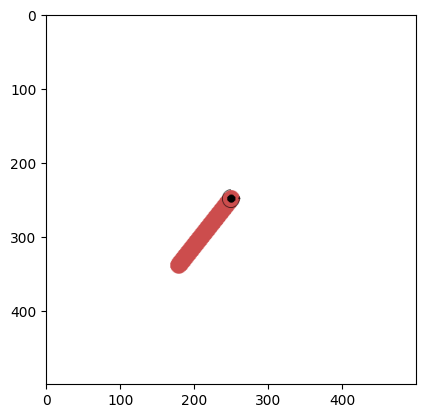

In [ ]:
## Test the code:
test_env = gym.make("Pendulum-v1", render_mode="rgb_array")
test_actor = MLPGaussianActor(obs_dim, act_dim).to(device)
steps = 50

sample_and_animate_trajectory(test_env, test_actor, steps)

test_env.close()

## How can we reduce variance?

**1. Don’t Let the Past Distract You**

One way to reduce the variance of the policy gradient is to **exploit causality**: the notion that
the policy cannot affect rewards in the past

$$\nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}{\left[
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) \sum_{t'=t}^T R(s_{t'}, a_{t'})\right]},$$

In this form, actions are only reinforced based on rewards obtained after they are taken.

We’ll call this form the “reward-to-go policy gradient” because it depends on the **reward-to-go** starting from a state-action pair of the trajectory:

$$\hat{Q}(s_t, a_t) = \sum_{t'=t}^T R(s_{t'}, a_{t'})$$

**2. Use a Baseline**

If all rewards are positive and unscaled, the policy gradient tries to increase the probability of each action (with different magnitudes). By introducing a baseline, the rewards are centered around zero. A common baseline is the mean of the trajectory returns.

**3. Use a Discount Factor**

Multiplying a discount factor $\gamma$ to the rewards can be interpreted as encouraging the agent
to focus on rewards closer to the present, which can also be thought of as means for reducing
variance (because there is more variance possible further into the future).
However in this notebook, we don't examine the effects of discounting and always assume $\gamma = 1$.

## Reward of trajectory

The policy gradient has the equation:

$$\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}\left(
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t^{(i)}|s_t^{(i)})\right) \left( \sum_{t=0}^T R(s_t^{(i)}, a_t^{(i)})\right)$$
    
Or using reward-to-go:

$$\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t^{(i)}|s_t^{(i)})\left(\sum_{t'=t}^T R(s_{t'}^{(i)}, a_{t'}^{(i)})\right)$$

In [ ]:
def sum_of_rewards(ep_rews):
    ep_ret = np.sum(ep_rews)
    return np.full_like(ep_rews, ep_ret)

In [ ]:
def sum_of_rewards_to_go(ep_rews):
    ep_len = ep_rews.size

    rews_to_go = np.zeros_like(ep_rews)

    for i in reversed(range(ep_len)):
        rews_to_go[i] = ep_rews[i] + (rews_to_go[i + 1] if i + 1 < ep_len else 0)

    return rews_to_go

We'll test the two types of rewards:

In [ ]:
# Test the code: in one episode we got four rewards {1,2,3,4}. Calculate the episode rewards
ep_rews = np.array([1,2,3,4])
sum_of_rewards(ep_rews)

array([10, 10, 10, 10])

In [ ]:
# Test the code: in one episode we got four rewards {1,2,3,4}. Calculate the rewards to go
ep_rews = np.array([1,2,3,4])
sum_of_rewards_to_go(ep_rews)

array([10,  9,  7,  4])

## Loss functions

In [ ]:
# Set up function for computing PG policy loss
def compute_loss_pi(data, actor):
    obs, act, ret, = data['obs'], data['act'], data['ret']

    # Policy loss
    pi, logp = actor(obs, act)
    loss_pi = -(logp * ret).mean()

    return loss_pi

In [ ]:
# Set up function for computing PG policy loss with baseline
def compute_loss_pi_with_baseline(data, actor):
    obs, act, ret = data["obs"], data["act"], data["ret"]

    with torch.no_grad():
        baseline = ret.mean()

    # Policy loss
    pi, logp = actor(obs, act)
    loss_pi = -(logp * (ret - baseline)).mean()

    return loss_pi

## Buffer

We define a buffer that stores the sampled trajectories consecutively. After a trajectory has ended, the method "finish_path" must be called so that the relevant statistics are computed.

In [ ]:
class Buffer:
    """
    A buffer for storing trajectories experienced by an agent interacting with the environment.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.bas_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size  # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0, rewards_to_go=False, advantage=False):
        """
        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates if the argument
        "advantage" is true, as well as the rewards-to-go for each state if
        the argument "rewards_to_go" is true and the total sum of rewards otherwise.
        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)

        self.ret_buf[path_slice] = (
            sum_of_rewards_to_go(rews[:-1])
            if rewards_to_go
            else sum_of_rewards(rews[:-1])
        )
        if advantage:
            self.adv_buf[path_slice] = advantage_with_v(rews, vals)

        self.path_start_idx = self.ptr

    def get(self):
        """
        Call this at the end of an epoch to get all of the data from
        the buffer. Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size  # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        data = dict(
            obs=self.obs_buf,
            act=self.act_buf,
            ret=self.ret_buf,
            adv=self.adv_buf,
            logp=self.logp_buf,
        )
        return {
            k: torch.as_tensor(v, dtype=torch.float32, device=device)
            for k, v in data.items()
        }

## Training

The training procedure consists of several “epochs”. An "epoch" is defined as

1. the experience collection step, where the agent acts for some number of episodes in the environment using the most recent policy, followed by
2. a single policy gradient update step.

In [ ]:
class PG:
    def __init__(
        self,
        env,
        max_ep_len=200,
        steps_per_epoch=4000,
        epochs=50,
        rewards_to_go=False,
        with_baseline=False,
        actor_hidden_sizes=(64,),
        actor_activation=nn.ReLU,
        actor_lr=1e-3,
    ):
        self.env = env
        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]
        self.max_ep_len = max_ep_len
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.rewards_to_go = rewards_to_go
        self.with_baseline = with_baseline

        self.buffer = Buffer(obs_dim, act_dim, steps_per_epoch)
        exp_name = (
            "PG" + ("_toGo" if rewards_to_go else "") + ("_wB" if with_baseline else "")
        )
        self.logger = Logger(exp_name)

        self.actor = MLPGaussianActor(
            obs_dim, act_dim, actor_hidden_sizes, actor_activation
        ).to(device)
        self.actor.to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)

    def update(self):
        data = self.buffer.get()

        # Train actor/policy with a single step of gradient descent
        self.actor_optimizer.zero_grad()
        loss_pi = (
            compute_loss_pi(data, self.actor)
            if not self.with_baseline
            else compute_loss_pi_with_baseline(data, self.actor)
        )
        loss_pi.backward()
        self.actor_optimizer.step()

    def train(self):
        # Prepare for interaction with environment
        obs, _ = self.env.reset()
        ep_ret, ep_len = 0, 0

        # Main loop: collect experience in env and update/log each epoch
        for epoch in range(self.epochs):
            for t in range(self.steps_per_epoch):
                act, logp = self.actor.step(
                    torch.as_tensor(obs, dtype=torch.float32, device=device)
                )

                next_obs, rew, terminated, truncated, _ = self.env.step(act)
                ep_ret += rew
                ep_len += 1

                # save
                self.buffer.store(obs, act, rew, 0, logp)

                # Update obs (critical!)
                obs = next_obs

                timeout = (ep_len == self.max_ep_len) or truncated
                terminal = terminated or timeout
                epoch_ended = (t == self.steps_per_epoch - 1)

                if terminal or epoch_ended:
                    if epoch_ended and not (terminal):
                        print(
                            f"Warning: trajectory cut off by epoch at {ep_len} steps.",
                            flush=True,
                        )
                    self.buffer.finish_path(rewards_to_go=self.rewards_to_go)
                    if terminal:
                        # only save ep_ret / ep_len if trajectory finished
                        self.logger.store(ep_ret=ep_ret, ep_len=ep_len)

                    obs, _ = self.env.reset()
                    ep_ret, ep_len = 0, 0

            # Perform update!
            self.update()

## Evaluation

### Policy Gradient

In [ ]:
pg = PG(env)
pg.train()
pg.logger.save_data_in_file()
pg.logger.save_model(pg.actor)

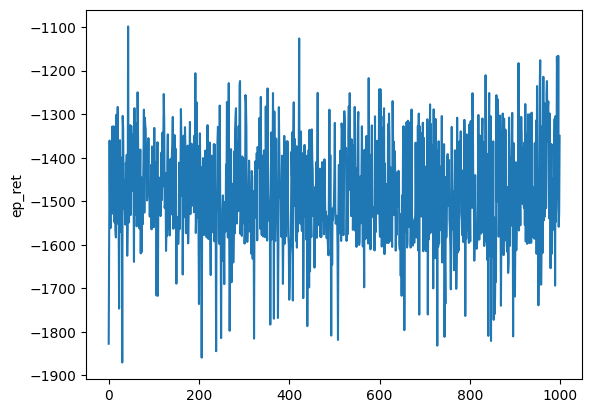

In [ ]:
data = pg.logger.get_data()
# data = pd.read_csv("")
plot(data, "ep_ret")

### Policy Gradient with Rewards-To-Go

In [ ]:
pg_toGo = PG(env, rewards_to_go=True)
pg_toGo.train()
pg_toGo.logger.save_data_in_file()
pg_toGo.logger.save_model(pg_toGo.actor)

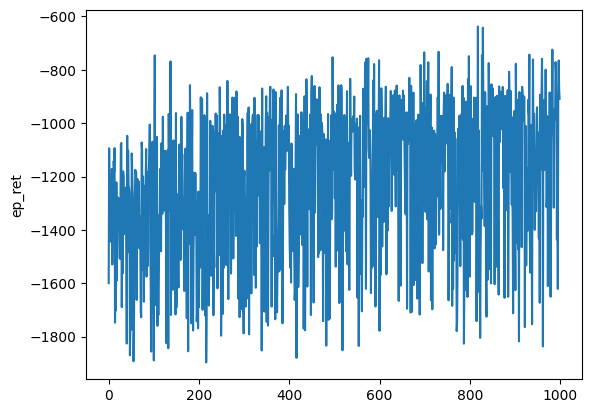

In [ ]:
data = pg_toGo.logger.get_data()
# data = pd.read_csv("")
plot(data, "ep_ret")

### Policy Gradient with Baseline

In [ ]:
pg_wB = PG(env, with_baseline=True)
pg_wB.train()
pg_wB.logger.save_data_in_file()
pg_wB.logger.save_model(pg_wB.actor)

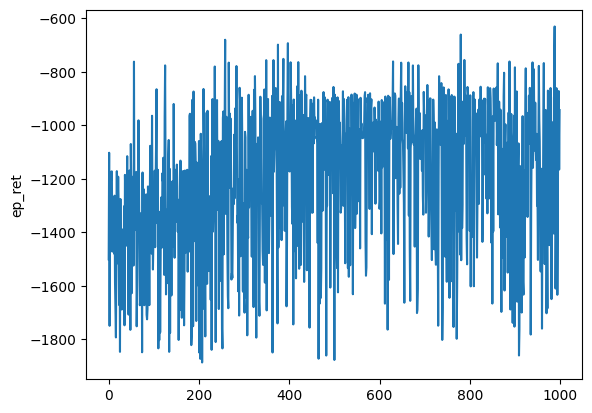

In [ ]:
data = pg_wB.logger.get_data()
# data = pd.read_csv("")
plot(data, "ep_ret")

# Actor-Critic

Actor-Critic methods combine the ideas of policy-based and value-based reinforcement learning. They also learn the $V_\phi$ function with a feedforward neural net with parameters $\phi$ so that the advantage of an action can be computed.

Here, the V function is learned by minimizing the error
$$\frac{1}{N} \sum_{i=1}^{N}\sum_{t=0}^{T} \left(V_\phi(s_t^{(i)}) - \left(\sum_{t'=t}^{T}R(s_{t'}^{(i)}, a_{t'}^{(i)})\right)\right)^2$$

In [ ]:
# Set up function for computing value loss
def compute_loss_v(data, v):
    obs, ret = data['obs'], data['ret']
    return ((v(obs) - ret)**2).mean()

The advantage is then computed with bootstrapping:
$$\hat{A}(s_t, a_t) = R(s_t, a_t) + V_\phi(s_{t+1}) - V_\phi(s_t)$$

In [ ]:
def advantage_with_v(rews, vals):
    adv = rews[:-1] + vals[1:] - vals[:-1]
    return adv

The policy/actor gradient is then:

$$\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t^{(i)}|s_t^{(i)})\hat{A}(s_t, a_t)$$

In [ ]:
 # Set up function for computing AC policy loss
def compute_loss_pi_with_advantage(data, actor):
    obs, act, adv = data['obs'], data['act'], data['adv']

    # Policy loss
    pi, logp = actor(obs, act)
    loss_pi = -(logp * adv).mean()

    return loss_pi

We can put now everything together to create an Actor-Critic. Notice that there exists an inner loop in the "update" method that is responsible for the Critic/Value function learning.

In [ ]:
class ActorCritic(nn.Module):
    def __init__(
        self,
        env,
        max_ep_len=200,
        steps_per_epoch=4000,
        epochs=50,
        actor_hidden_sizes=(64,),
        actor_activation=nn.ReLU,
        actor_lr=1e-3,
        critic_hidden_sizes=(64,),
        critic_activation=nn.ReLU,
        critic_lr=1e-3,
        train_v_iters=80,
    ):
        super().__init__()
        self.env = env
        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]
        self.max_ep_len = max_ep_len
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs

        self.buffer = Buffer(obs_dim, act_dim, steps_per_epoch)
        self.logger = Logger("AC")

        self.actor = MLPGaussianActor(
            obs_dim, act_dim, actor_hidden_sizes, actor_activation
        ).to(device)
        self.actor.to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)

        self.critic = mlp(obs_dim, critic_hidden_sizes, 1, critic_activation)
        self.critic.to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.train_v_iters = train_v_iters

    def update(self):
        data = self.buffer.get()

        # Train actor/policy with a single step of gradient descent
        self.actor_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data, self.actor)
        loss_pi.backward()
        self.actor_optimizer.step()

        # Critic/Value function learning
        for i in range(self.train_v_iters):
            self.critic_optimizer.zero_grad()
            loss_v = compute_loss_v(data, self.critic)
            loss_v.backward()
            self.critic_optimizer.step()

    def step(self, obs):
        act, logp = self.actor.step(obs)
        with torch.no_grad():
            val = self.critic(obs)
        return act, logp, val.cpu().numpy()

    def train(self):
        # Prepare for interaction with environment
        obs, _ = self.env.reset()
        ep_ret, ep_len = 0, 0

        # Main loop: collect experience in env and update/log each epoch
        for epoch in range(self.epochs):
            for t in range(self.steps_per_epoch):
                act, logp, val = self.step(
                    torch.as_tensor(obs, dtype=torch.float32, device=device)
                )

                next_obs, rew, terminated, truncated, _ = self.env.step(act)
                ep_ret += rew
                ep_len += 1

                # save
                self.buffer.store(obs, act, rew, val, logp)

                # Update obs (critical!)
                obs = next_obs

                timeout = (ep_len == self.max_ep_len) or truncated
                terminal = terminated or timeout
                epoch_ended = t == self.steps_per_epoch - 1

                if terminal or epoch_ended:
                    if epoch_ended and not (terminal):
                        print(
                            f"Warning: trajectory cut off by epoch at {ep_len} steps.",
                            flush=True,
                        )
                    # if trajectory didn't reach terminal state, bootstrap value target
                    if timeout or epoch_ended:
                        _, val, _ = self.step(
                            torch.as_tensor(obs, dtype=torch.float32, device=device)
                        )
                    else:  # terminated
                        val = 0
                    self.buffer.finish_path(val, rewards_to_go=True, advantage=True)
                    if terminal:
                        # only save EpRet / EpLen if trajectory finished
                        self.logger.store(ep_ret=ep_ret, ep_len=ep_len)

                    obs, _ = self.env.reset()
                    ep_ret, ep_len = 0, 0

            # Perform update!
            self.update()

## Evaluation of Actor-Critic

In [ ]:
ac = ActorCritic(env)
ac.train()
ac.logger.save_data_in_file()
ac.logger.save_model(ac)

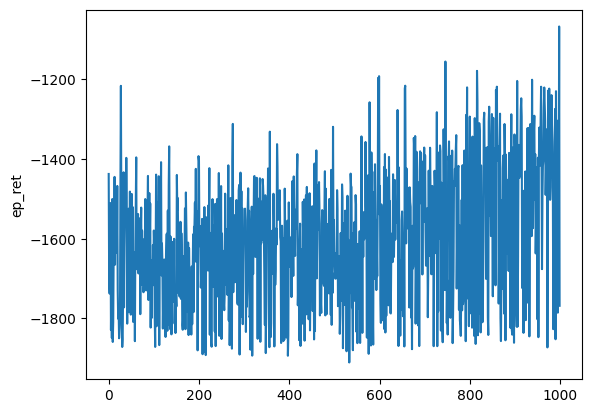

In [ ]:
data = ac.logger.get_data()
# data = pd.read_csv("")
plot(data, "ep_ret")

In [ ]:
## Test the Actor-Critic:
test_env = gym.make("Pendulum-v1", render_mode="rgb_array")
steps = 50

test_ac = ActorCritic(env).to(device)
state_dict = torch.load("log/AC_2023-05-16_00-59-42/model.pt")
test_ac.load_state_dict(state_dict)

sample_and_animate_trajectory(test_env, test_ac.actor, steps)

test_env.close()

FileNotFoundError: ignored